In [24]:
import findspark
findspark.init()
findspark.find()

'd:\\Cardio Disease Pyspark Web App\\venv\\lib\\site-packages\\pyspark'

In [25]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, sum,when,round
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors
import pandas as pd
spark=SparkSession.builder.appName('Sampleapp').getOrCreate()


# Read CSV

In [26]:
df=spark.read.csv('D:/R/CardioVascularDisease/cardio_train.csv',header=True,sep=";")
df.cache()
df.show()

+----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+----+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| 988|22469|     1|   155|  69.0|  130|   80|          2|   2|    0|   0|     1|     0|
| 989|14648|     1|   163|  71.0|  110|   70|          1|   1|    0|   0|     1|     1|
| 990|21901|     1|   165|  70.0|  120|   80|          1|   1|    0|   0|     1|     0|
| 991|14549|     2|   165|  85.0|  120|   80|          1|   1|    1|   1|     1|     0|
| 992|23393|     1|   155|  62.0|  120|   80|          1|   1|    0|   0|     1|     0|
| 995|21143|     1|   164|  61.0|  100|   70|          1|   1|    0|   0|     1|     0|
| 996|18085|     1|   162|  72.0|  100|   70|          1|   1|    0|   0|     1|     0|
| 997|22547|     1|   161|  93.0|  140|   90|          2|   1|    0|   0|     1|     1|
| 999|21250|     1|   157|  68.0

In [27]:
rows=df.count()
cols=len(df.columns)
print('Number of Rows are :',rows)
print('Number of Columns are :',cols)

Number of Rows are : 69301
Number of Columns are : 13


In [28]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- ap_hi: string (nullable = true)
 |-- ap_lo: string (nullable = true)
 |-- cholesterol: string (nullable = true)
 |-- gluc: string (nullable = true)
 |-- smoke: string (nullable = true)
 |-- alco: string (nullable = true)
 |-- active: string (nullable = true)
 |-- cardio: string (nullable = true)



# Modify Schema

In [29]:
# Change Schema
df=df.withColumn("weight",col('weight').cast('float'))
cols=['age','gender','height','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active','cardio']
for i in cols:
    df=df.withColumn(i,col(i).cast('integer'))

df.printSchema()

root
 |-- id: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: float (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)



# NA Values

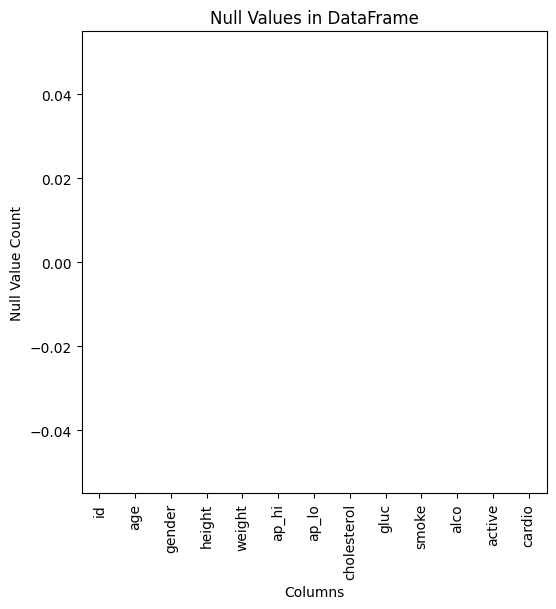

In [30]:


null_counts = df.select([sum(col(col_name).isNull().cast('int')).alias(col_name) for col_name in df.columns])
# Convert the null counts DataFrame to Pandas for visualization
null_counts_pd = null_counts.toPandas()
plt.figure(figsize=(6,6))
sns.barplot(data=null_counts_pd)
plt.xlabel('Columns')
plt.ylabel('Null Value Count')
plt.title('Null Values in DataFrame')
plt.xticks(rotation=90)
plt.show()

In [31]:
# Dupicates
dup_count=df.groupBy(df.columns).count()
duplicate=dup_count.where(col('count')>1)
duplicate.show()

+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+
| id|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|count|
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+



# Class with Labels

In [32]:
# Unique Values
sd=['gender','cardio','smoke','gluc']
for column_name in sd:
    class_counts = df.groupBy(column_name).count().collect()
    print(f"Distinct classes and counts in {column_name}:")
    for row in class_counts:
        class_value = row[column_name]
        count = row["count"]
        print(f"Class: {class_value}, Count: {count}")
    print()

Distinct classes and counts in gender:
Class: 1, Count: 45079
Class: 2, Count: 24222

Distinct classes and counts in cardio:
Class: 1, Count: 34622
Class: 0, Count: 34679

Distinct classes and counts in smoke:
Class: 1, Count: 6102
Class: 0, Count: 63199

Distinct classes and counts in gluc:
Class: 1, Count: 58885
Class: 3, Count: 5277
Class: 2, Count: 5139



# Visualization

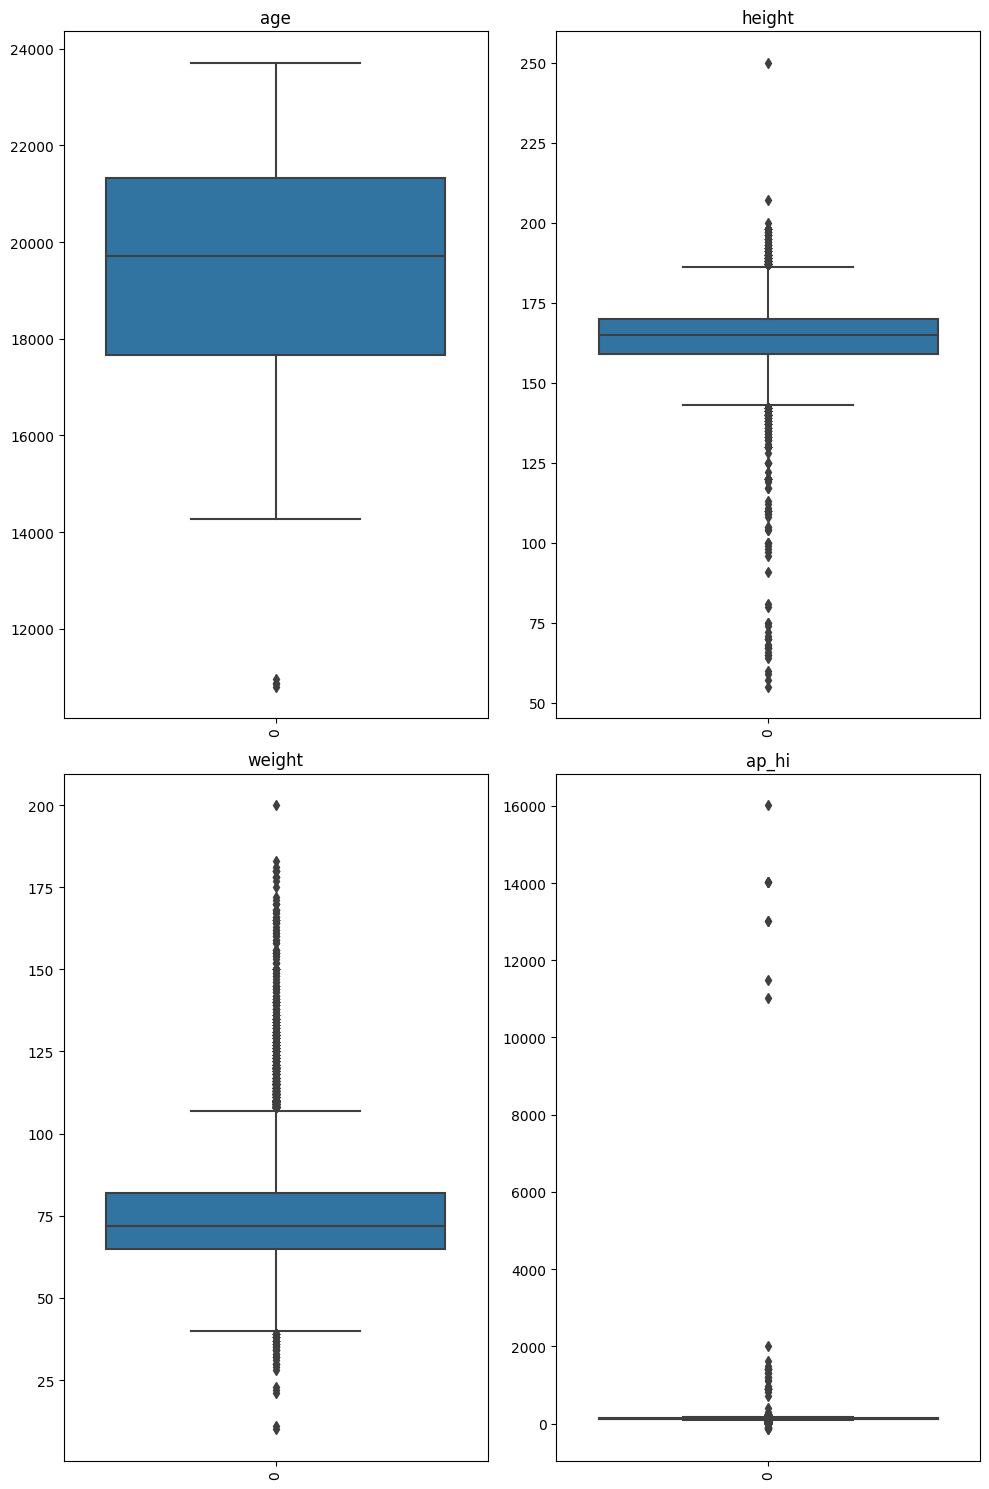

In [33]:
boxes=['age','height','weight','ap_hi']
pandabox=df.select(boxes).toPandas()
# VISUALISING BOXPLOT
fig, ax = plt.subplots(2, 2, figsize=(10, 15))
for i, (variable, subplot) in enumerate(zip(boxes, ax.flatten())):
    sns.boxplot(pandabox[variable], ax=subplot)
    subplot.set_title(variable)  # Set the title to the column name
    subplot.tick_params(axis='x', rotation=90)  # Rotate x-axis labels

plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

# Outlier Treatment

In [34]:
# Outlier finder

def out_find(data,colname):
    for i in colname:
        quantiles=data.approxQuantile(i,[0.25,0.75],0.01)
        q1=quantiles[0]
        q3=quantiles[1]
        iqr=q3-q1
        lower=q1-(1.5*iqr)
        upper=q3+(1.5*iqr)
     # Identify the outliers based on the bounds
        data = data.withColumn(i, when(col(i) < lower, lower)
                                          .when(col(i) > upper, upper)
                                          .otherwise(col(i)))

    return data
boxes=['age','height','weight','ap_hi']
df = out_find(df, boxes)
df.show()

+----+-------+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  id|    age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+----+-------+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| 988|22469.0|     1| 155.0|  69.0|130.0|   80|          2|   2|    0|   0|     1|     0|
| 989|14648.0|     1| 163.0|  71.0|110.0|   70|          1|   1|    0|   0|     1|     1|
| 990|21901.0|     1| 165.0|  70.0|120.0|   80|          1|   1|    0|   0|     1|     0|
| 991|14549.0|     2| 165.0|  85.0|120.0|   80|          1|   1|    1|   1|     1|     0|
| 992|23393.0|     1| 155.0|  62.0|120.0|   80|          1|   1|    0|   0|     1|     0|
| 995|21143.0|     1| 164.0|  61.0|100.0|   70|          1|   1|    0|   0|     1|     0|
| 996|18085.0|     1| 162.0|  72.0|100.0|   70|          1|   1|    0|   0|     1|     0|
| 997|22547.0|     1| 161.0|  93.0|140.0|   90|          2|   1|    0|   0|     1|     1|
| 999|2125

<Axes: >

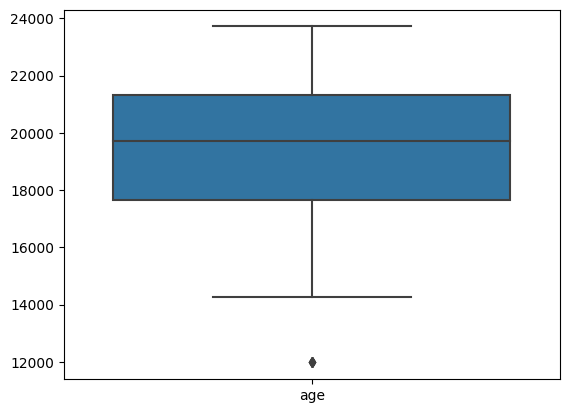

In [35]:
sample=df.select('age').toPandas()
sns.boxplot(sample)

# Feature Engineering

In [36]:
df=df.withColumn('bmi',col('weight')/col('height')**2)
# age in years
df=df.withColumn('age',round(col('age')/365))
df.show()

+----+----+------+------+------+-----+-----+-----------+----+-----+----+------+------+--------------------+
|  id| age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|                 bmi|
+----+----+------+------+------+-----+-----+-----------+----+-----+----+------+------+--------------------+
| 988|62.0|     1| 155.0|  69.0|130.0|   80|          2|   2|    0|   0|     1|     0|0.002872008324661...|
| 989|40.0|     1| 163.0|  71.0|110.0|   70|          1|   1|    0|   0|     1|     1|0.002672287252060672|
| 990|60.0|     1| 165.0|  70.0|120.0|   80|          1|   1|    0|   0|     1|     0|0.002571166207529...|
| 991|40.0|     2| 165.0|  85.0|120.0|   80|          1|   1|    1|   1|     1|     0|0.003122130394857...|
| 992|64.0|     1| 155.0|  62.0|120.0|   80|          1|   1|    0|   0|     1|     0|0.002580645161290...|
| 995|58.0|     1| 164.0|  61.0|100.0|   70|          1|   1|    0|   0|     1|     0|0.002267995240928019|
| 996|50.0|     1| 162.0|  7

# Correlation Matrix

             age    height    weight     ap_hi       bmi
age     1.000000 -0.086339  0.060077  0.209508  0.109590
height -0.086339  1.000000  0.316015  0.016549 -0.217706
weight  0.060077  0.316015  1.000000  0.274898  0.852751
ap_hi   0.209508  0.016549  0.274898  1.000000  0.272436
bmi     0.109590 -0.217706  0.852751  0.272436  1.000000


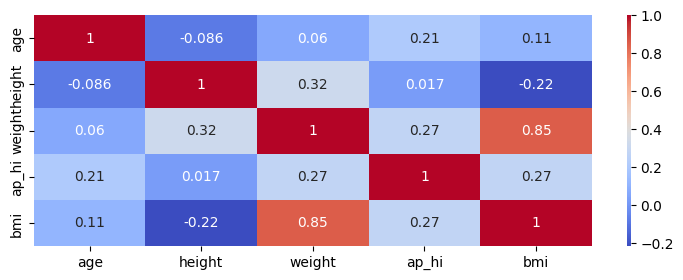

In [37]:
numcols=['age','height','weight','ap_hi','bmi']
data=df.select(numcols)
# Convert df into rdd of vectors
rdd_vect=data.rdd.map(lambda row: Vectors.dense(row))
corr_mat=Statistics.corr(rdd_vect,method='pearson')
corr_df=pd.DataFrame(corr_mat,columns=numcols,index=numcols)
print(corr_df)
plt.figure(figsize=(9,3))
sns.heatmap(corr_df,annot=True,cmap='coolwarm',cbar_kws={"aspect":60})
plt.show()

# Aggregation

In [38]:
from pyspark.sql import functions as f
cardio=df.groupBy('cardio').agg(f.avg('weight'),f.avg('height'),f.max('weight'),f.min('weight')).show()
gen=df.groupBy('gender').agg(f.avg('weight'),f.avg('height'),f.max('weight'),f.min('weight')).show()
ages=df.where((df['weight']>100)&(df['gender']==1) &(df['cardio']==1)).show()
total_class=df.groupBy('cardio').count().show()

+------+-----------------+------------------+-----------+-----------+
|cardio|      avg(weight)|       avg(height)|max(weight)|min(weight)|
+------+-----------------+------------------+-----------+-----------+
|     1|76.41980821460642| 164.3125324937901|      107.5|       39.5|
|     0|71.43265520918241|164.50673318146428|      107.5|       39.5|
+------+-----------------+------------------+-----------+-----------+

+------+-----------------+------------------+-----------+-----------+
|gender|      avg(weight)|       avg(height)|max(weight)|min(weight)|
+------+-----------------+------------------+-----------+-----------+
|     1|72.31868386637252|161.41679052330355|      107.5|       39.5|
|     2|76.91213359727246|169.97977045660969|      107.5|       39.5|
+------+-----------------+------------------+-----------+-----------+

+----+----+------+------+------+-----+-----+-----------+----+-----+----+------+------+--------------------+
|  id| age|gender|height|weight|ap_hi|ap_lo|choles

# Build Pipeline(String Indexer>Onehot Encoding>Vector Assembler>Minmax)

In [39]:
# One hot encoding of categories
from pyspark.ml.feature import OneHotEncoder,VectorAssembler,StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler
stages = []
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# Create a list of column names for numerical features
num_cols = ['age', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo']

# One-hot encoding for categorical columns
for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[col + "_encoded"])
    stages += [indexer, encoder]

# Scaling for numerical columns
assembler_inputs = [col + "_encoded" for col in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="assembled_features")
scaler = MinMaxScaler(inputCol="assembled_features", outputCol="scaled_features")
stages += [assembler, scaler]

# Step 2: Create the pipeline
pipeline = Pipeline(stages=stages)

# Step 3: Fit the pipeline to the data
pipeline_model = pipeline.fit(df)

# Step 4: Transform the data
final_df = pipeline_model.transform(df)
final_df.cache()
final_df.show()

+----+----+------+------+------+-----+-----+-----------+----+-----+----+------+------+--------------------+------------+--------------+-----------------+-------------------+----------+-------------+-----------+-------------+----------+-------------+------------+--------------+--------------------+--------------------+
|  id| age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|                 bmi|gender_index|gender_encoded|cholesterol_index|cholesterol_encoded|gluc_index| gluc_encoded|smoke_index|smoke_encoded|alco_index| alco_encoded|active_index|active_encoded|  assembled_features|     scaled_features|
+----+----+------+------+------+-----+-----+-----------+----+-----+----+------+------+--------------------+------------+--------------+-----------------+-------------------+----------+-------------+-----------+-------------+----------+-------------+------------+--------------+--------------------+--------------------+
| 988|62.0|     1| 155.0|  69.0|130.0|  

In [40]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)
lr = LogisticRegression(labelCol='cardio', featuresCol='scaled_features', maxIter=10)
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol='cardio')
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")



Accuracy: 0.7938853405868552


In [41]:
# Show the predictions and probabilities
predictions.select("cardio", "prediction", "probability").show()

+------+----------+--------------------+
|cardio|prediction|         probability|
+------+----------+--------------------+
|     0|       0.0|[0.68210773255308...|
|     0|       0.0|[0.76469535740091...|
|     1|       1.0|[0.39943227016795...|
|     0|       0.0|[0.85942227886446...|
|     1|       1.0|[0.44469574418209...|
|     1|       1.0|[0.34194283532394...|
|     1|       1.0|[0.32062911070137...|
|     1|       1.0|[0.03057359671482...|
|     1|       1.0|[0.03230269292979...|
|     1|       1.0|[0.17973668409037...|
|     0|       0.0|[0.63332506974815...|
|     1|       1.0|[0.15293653706139...|
|     0|       1.0|[0.39342582368157...|
|     0|       1.0|[0.40620754308509...|
|     0|       0.0|[0.84274374182818...|
|     0|       0.0|[0.74626970081715...|
|     0|       0.0|[0.62469209449032...|
|     1|       1.0|[0.21633966552829...|
|     0|       0.0|[0.76535293747104...|
|     0|       0.0|[0.90165865055782...|
+------+----------+--------------------+
only showing top

In [42]:
# Make predictions on the test data
predictions = lr_model.transform(test_data)
# Show the predictions and probabilities
predictions.select("cardio", "prediction", "probability").show()


+------+----------+--------------------+
|cardio|prediction|         probability|
+------+----------+--------------------+
|     0|       0.0|[0.68210773255308...|
|     0|       0.0|[0.76469535740091...|
|     1|       1.0|[0.39943227016795...|
|     0|       0.0|[0.85942227886446...|
|     1|       1.0|[0.44469574418209...|
|     1|       1.0|[0.34194283532394...|
|     1|       1.0|[0.32062911070137...|
|     1|       1.0|[0.03057359671482...|
|     1|       1.0|[0.03230269292979...|
|     1|       1.0|[0.17973668409037...|
|     0|       0.0|[0.63332506974815...|
|     1|       1.0|[0.15293653706139...|
|     0|       1.0|[0.39342582368157...|
|     0|       1.0|[0.40620754308509...|
|     0|       0.0|[0.84274374182818...|
|     0|       0.0|[0.74626970081715...|
|     0|       0.0|[0.62469209449032...|
|     1|       1.0|[0.21633966552829...|
|     0|       0.0|[0.76535293747104...|
|     0|       0.0|[0.90165865055782...|
+------+----------+--------------------+
only showing top

# Check Best Model

In [43]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier,GBTClassifier,LogisticRegression, DecisionTreeClassifier, NaiveBayes, LinearSVC
# Build models using different algorithms
models = [
    RandomForestClassifier(labelCol='cardio', featuresCol='scaled_features', seed=42),
    GBTClassifier(labelCol='cardio',featuresCol='scaled_features',maxIter=10),
    LogisticRegression(labelCol='cardio', featuresCol='scaled_features', maxIter=10),
    DecisionTreeClassifier(labelCol='cardio', featuresCol='scaled_features', seed=42),
    NaiveBayes(labelCol='cardio', featuresCol='scaled_features'),
    LinearSVC(labelCol='cardio', featuresCol='scaled_features', maxIter=10)
]

model_names = [
    "Random Forest",
    "Gradient Boost",
    "Logistic Regression",
    "Decision Tree",
    "Naive Bayes",
    "Linear SVC"
]

# Define the parameter grid for each model
paramGrids = [
    ParamGridBuilder().build(),  # Random Forest doesn't require hyperparameter tuning
    ParamGridBuilder().build(),  # Logistic Regression doesn't require hyperparameter tuning
    ParamGridBuilder().build(),  # Decision Tree doesn't require hyperparameter tuning
    ParamGridBuilder().build(),  # Naive Bayes doesn't require hyperparameter tuning
    ParamGridBuilder().build(),   # Linear SVC doesn't require hyperparameter tuning
    ParamGridBuilder().build()
]

# Perform cross-validation and select the best model
evaluator = BinaryClassificationEvaluator(labelCol='cardio')
best_accuracy = 0.0
best_model = None
best_model_name = None

for i, model in enumerate(models):
    # Create cross-validator
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=paramGrids[i],
                              evaluator=evaluator,
                              numFolds=5,
                              seed=42)
    
    # Fit cross-validation models
    cv_model = crossval.fit(train_data)
    
    # Make predictions on the test data
    cv_predictions = cv_model.transform(test_data)
    
    # Evaluate the performance of the model using accuracy
    accuracy = evaluator.evaluate(cv_predictions)
    
    print(f"{model_names[i]} Accuracy: {accuracy}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = cv_model
        best_model_name = model_names[i]

print(f"\nBest Model: {best_model_name} with Accuracy: {best_accuracy}")

Random Forest Accuracy: 0.7937894006852235
Gradient Boost Accuracy: 0.8024631056351511
Logistic Regression Accuracy: 0.7938853405868552
Decision Tree Accuracy: 0.6094376796656572
Naive Bayes Accuracy: 0.3985548356767784
Linear SVC Accuracy: 0.7930976122358242

Best Model: Gradient Boost with Accuracy: 0.8024631056351511


# Hyper Parameter Tunning

In [57]:
# Define the Gradient Boosting Classifier
gbt = GBTClassifier(labelCol='cardio', featuresCol='scaled_features', seed=42)

# Define the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 10, 15])
             .addGrid(gbt.maxIter, [10, 20, 30])
             .addGrid(gbt.stepSize, [0.1, 0.05, 0.01])
             .addGrid(gbt.maxBins, [16, 32])
             .build())

# Define the evaluator
evaluator = BinaryClassificationEvaluator(labelCol='cardio')

# Create cross-validator
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5,
                          seed=42)

# Fit cross-validation models
cv_model = crossval.fit(train_data)

# Make predictions on the test data
cv_predictions = cv_model.transform(test_data)

# Evaluate the performance of the model using accuracy
accuracy = evaluator.evaluate(cv_predictions)

print(f"Gradient Boosting Classifier Accuracy: {accuracy}")

Gradient Boosting Classifier Accuracy: 0.8035224089276158


In [60]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='cardio', predictionCol='prediction', metricName='accuracy')

# Compute the accuracy
accuracy = evaluator.evaluate(cv_predictions)

# Get the predictions and labels
predictionsAndLabels = cv_predictions.select(['prediction', 'cardio']).show()



+----------+------+
|prediction|cardio|
+----------+------+
|       0.0|     0|
|       0.0|     0|
|       1.0|     1|
|       0.0|     0|
|       1.0|     1|
|       1.0|     1|
|       1.0|     1|
|       1.0|     1|
|       1.0|     1|
|       1.0|     1|
|       0.0|     0|
|       1.0|     1|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       1.0|     1|
|       0.0|     0|
|       0.0|     0|
+----------+------+
only showing top 20 rows



In [67]:
import mlflow

model_path = 'D:/Cardio Disease Pyspark Web App/model'
mlflow.spark.save_model(cv_model.bestModel, model_path)


ModuleNotFoundError: No module named 'mlflow'

# Plot Results

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix

# Make predictions on the test data using the best model
predictions = best_model.transform(test_data)

# Extract probability of positive class (cardio) from predictions
probs = np.array(predictions.select('probability').collect())
probs = probs.reshape(-1)  # Reshape to a 1-dimensional array

# Extract true labels from test data
labels = np.array(predictions.select('cardio').collect())
labels = labels.reshape(-1)  # Reshape to a 1-dimensional array

# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR) for ROC curve
fpr, tpr, thresholds = roc_curve(labels, probs)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

# Create a confusion matrix to compare actual vs. predicted values
cm = confusion_matrix(labels, predictions.select('prediction').collect())
print("Confusion Matrix:")
print(cm)

# Calculate True Positive (TP), False Positive (FP), True Negative (TN), and False Negative (FN) from confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate True Positive Rate (TPR)
tpr = tp / (tp + fn)

# Calculate False Positive Rate (FPR)
fpr = fp / (fp + tn)

print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)


ValueError: Found input variables with inconsistent numbers of samples: [14009, 28018]

# Test Model on Unseen Data

In [111]:
%%time
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType

# Define the schema for the new data
schema = StructType([
    StructField("gender", IntegerType(), True),
    StructField("cholesterol", IntegerType(), True),
    StructField("gluc", IntegerType(), True),
    StructField("smoke", IntegerType(), True),
    StructField("alco", IntegerType(), True),
    StructField("active", IntegerType(), True),
    StructField("age", IntegerType(), True),
    StructField("height", IntegerType(), True),
    StructField("weight", IntegerType(), True),
    StructField("bmi", DoubleType(), True),
    StructField("ap_hi", IntegerType(), True),
    StructField("ap_lo", IntegerType(), True)
])
# Create new data points
new_data = [
    (1, 1, 1, 0, 1, 1, 50, 160, 60, 23.4, 120, 80),  # Example 1
    (0, 2, 1, 1, 0, 0, 65, 170, 70, 24.2, 130, 90)   # Example 2
]

# Create a DataFrame for the new data
new_data_df = spark.createDataFrame(new_data, schema)

# Transform the new data using the pipeline
new_data_transformed = pipeline_model.transform(new_data_df)

# Make predictions on the new data
predictions = lr_model.transform(new_data_transformed)

# Show the predictions and probabilities
predictions.select("prediction", "probability").show()


Py4JJavaError: An error occurred while calling o6933.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 392.0 failed 1 times, most recent failure: Lost task 2.0 in stage 392.0 (TID 313) (Golu executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (StringIndexerModel$$Lambda$4353/0x0000000802291d40: (string) => double).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:217)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1623)
Caused by: org.apache.spark.SparkException: Unseen label: 0. To handle unseen labels, set Param handleInvalid to keep.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:406)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 18 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4177)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3161)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4167)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:526)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4165)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4165)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3161)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3382)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:284)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:323)
	at jdk.internal.reflect.GeneratedMethodAccessor88.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1623)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (StringIndexerModel$$Lambda$4353/0x0000000802291d40: (string) => double).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:217)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: org.apache.spark.SparkException: Unseen label: 0. To handle unseen labels, set Param handleInvalid to keep.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:406)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 18 more


In [ ]:
spark.stop()